<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 21 15:53:15 2016

@author: agiovann
"""
from IPython.display import YouTubeVideo as yt
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div
import cv2
try:
    cv2.setNumThreads(1)
except:
    print('Open CV is naturally single threaded')

try:
    if __IPYTHON__:
        print((1))
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    print('Not IPYTHON')
    pass
#%%
import caiman as cm
import numpy as np
import os
import glob
import time
import pylab as pl
import psutil
import sys
from ipyparallel import Client
from skimage.external.tifffile import TiffFile
import scipy
#%%
from caiman.motion_correction import tile_and_correct, motion_correction_piecewise
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.motion_correction import MotionCorrect
from caiman.components_evaluation import evaluate_components 
from caiman.utils.visualization import plot_contours, view_patches_bar
from caiman.base.rois import extract_binary_masks_blob
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours,view_patches_bar,nb_plot_contour,nb_view_patches
import bokeh.plotting as bpl
from IPython.lib.display import YouTubeVideo as yt
bpl.output_notebook()

1


/Users/jeremie/anaconda2/envs/CaImAn/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


numba not found


Loading BokehJS ...

In [2]:
#%%
#m = cm.load('example_movies/demoMovie.tif')
#
#cm.concatenate([m.resize(1,1,.2),m.resize(1,1,.2)],axis =1).play(fr =20, gain = 3.,magnification =3)
#%% set parameters and create template by RIGID MOTION CORRECTION
params_movie = {'fname': ['Sue_2x_3000_40_-46.tif'],
                'niter_rig': 1,
                'max_shifts': (6, 6),  # maximum allow rigid shift
                'splits_rig': 56,  # for parallelization split the movies in  num_splits chuncks across time
                # if none all the splits are processed and the movie is saved
                'num_splits_to_process_rig': None,
                # intervals at which patches are laid out for motion correction
                'strides': (48, 48),
                # overlap between pathes (size of patch strides+overlaps)
                'overlaps': (24, 24),
                'splits_els': 56,  # for parallelization split the movies in  num_splits chuncks across time
                # if none all the splits are processed and the movie is saved
                'num_splits_to_process_els': [28, None],
                'upsample_factor_grid': 4,  # upsample factor to avoid smearing when merging patches
                # maximum deviation allowed for patch with respect to rigid
                # shift
                'max_deviation_rigid': 3,
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 0.8,  # merging threshold, max correlation allowed
                'rf': 15,  # half-size of the patches in pixels. rf=25, patches are 50x50
                'stride_cnmf': 6,  # amounpl.it of overlap between the patches in pixels
                'K': 4,  # number of components per patch
                # if dendritic. In this case you need to set init_method to
                # sparse_nmf
                'is_dendrites': False,
                'init_method': 'greedy_roi',
                'gSig': [4, 4],  # expected half size of neurons
                'alpha_snmf': None,  # this controls sparsity
                'final_frate': 30
                }

In [3]:
#%% parameters from dictionary
fname = params_movie['fname']
niter_rig = params_movie['niter_rig']
# maximum allow rigid shift
max_shifts = params_movie['max_shifts']  
# for parallelization split the movies in  num_splits chuncks across time
splits_rig = params_movie['splits_rig']  
# if none all the splits are processed and the movie is saved
num_splits_to_process_rig = params_movie['num_splits_to_process_rig']
# intervals at which patches are laid out for motion correction
strides = params_movie['strides']
# overlap between pathes (size of patch strides+overlaps)
overlaps = params_movie['overlaps']
# for parallelization split the movies in  num_splits chuncks across time
splits_els = params_movie['splits_els'] 
# if none all the splits are processed and the movie is saved
num_splits_to_process_els = params_movie['num_splits_to_process_els']
# upsample factor to avoid smearing when merging patches
upsample_factor_grid = params_movie['upsample_factor_grid'] 
# maximum deviation allowed for patch with respect to rigid
# shift
max_deviation_rigid = params_movie['max_deviation_rigid']

In [4]:
# %% download movie if not there                                                                                                                                                                                
if fname[0] in ['Sue_2x_3000_40_-46.tif','demoMovieJ.tif']:
    download_demo(fname[0])
    fname = [os.path.join('example_movies',fname[0])]
m_orig = cm.load_movie_chain(fname[:1])
yt('mLvNmPs9onE')
print("Data from Sue Ann Koay, Princeton Neuroscience Institute, Tank Lab.")

downloading Sue_2x_3000_40_-46.tifwith urllib


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


Data from Sue Ann Koay, Princeton Neuroscience Institute, Tank Lab.


In [5]:
#%% load movie (in memory!)
m_orig = cm.load_movie_chain(fname)
#%% play movie
downsample_ratio = .2
offset_mov = -np.min(m_orig[:100])
m_orig.resize(1, 1, downsample_ratio).play(
    gain=10, offset = offset_mov, fr=30, magnification=2)

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


reshaping along z


<em>some of the pixels in this movie are negative, we then need to make them positive </em>

<h2> Motion correction is performed in parallel on chunks taken across times. </h2>
<p> Create temporal chunks of the movie for  parallel processing on all cores </p>
<p> ipyparallel is used to create a cluster that handles the parallelization eithr on the PC ( see : https://ipyparallel.readthedocs.io/en/latest/intro.html) or on clusters interfacing with slurm ( see : https://slurm.schedmd.com/quickstart.html ) </p>
<p><img src="docs/img/cordermmap.png" /> </p>

In [6]:
#%% start the cluster
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

Stopping cluster...
NOT SLURM
No cluster to stop... done
Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
......Using 4 processes


<h1> Rigid motion correction</h1>
<p> We are now left with a really shacky video. In order to correct the image movement we are using a simple rigid motion correction algorithm. This algorithm first creates a correlation image over time using frames from the video. It then tries to match each frame to this template. In addition the template will get updated during the matching process. Making it more precise and so does the template matching.  </p>
<img src="docs/img/rigidcorrection.png" />
more info : <em> http://opencv.org/about.html </em>


Rigid Motion Correction
296.0
-296.0


caiman/base/movies.py:257: UserWarning: ** Pixels averages are too negative. Removing 1 percentile. **
  warnings.warn('** Pixels averages are too negative. Removing 1 percentile. **')
caiman/base/movies.py:275: UserWarning: Pixels averages are too negative for template. Removing 1 percentile.
  warnings.warn('Pixels averages are too negative for template. Removing 1 percentile.')


Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
-296.0
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
-296.0
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
Adding to movie 296.0
0
saving!


/Users/jeremie/anaconda2/envs/CaImAn/lib/python2.7/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in float_scalars
  return a / b


nan
mmap
reshaping along z


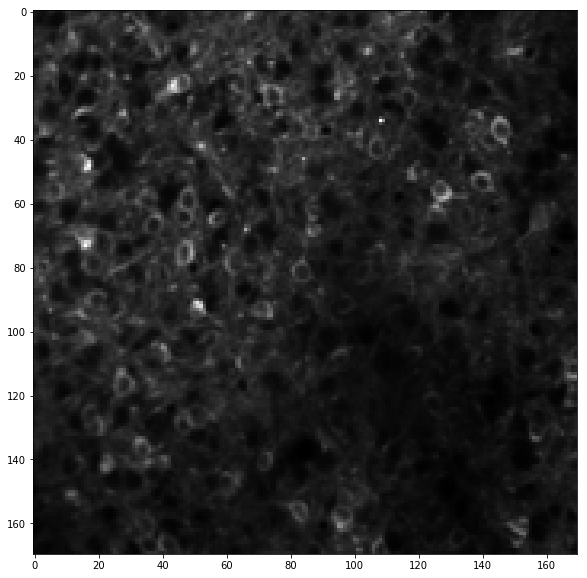

In [8]:
# movie must be mostly positive for this to work
min_mov = cm.load(fname[0], subindices=range(400)).min()

mc = MotionCorrect(fname[0], min_mov,
                   dview=dview, max_shifts=max_shifts, niter_rig=niter_rig,
                   splits_rig=splits_rig, 
                   num_splits_to_process_rig=num_splits_to_process_rig, 
                strides= strides, overlaps= overlaps, splits_els=splits_els,
                num_splits_to_process_els=num_splits_to_process_els, 
                upsample_factor_grid=upsample_factor_grid,
                   max_deviation_rigid=max_deviation_rigid, 
                shifts_opencv = True, nonneg_movie = True)
#%%
mc.motion_correct_rigid(save_movie=True)
# load motion corrected movie
m_rig = cm.load(mc.fname_tot_rig)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(np.int)
#%% visualize templates
pl.figure(figsize = (20,10))
pl.imshow(mc.total_template_rig, cmap = 'gray')
#%% inspect movie
m_rig.resize(1, 1, downsample_ratio).play(
    gain=10, offset = offset_mov*.25, fr=30, magnification=2,bord_px = bord_px_rig)

<h2> Inspect motion correction results</h2>

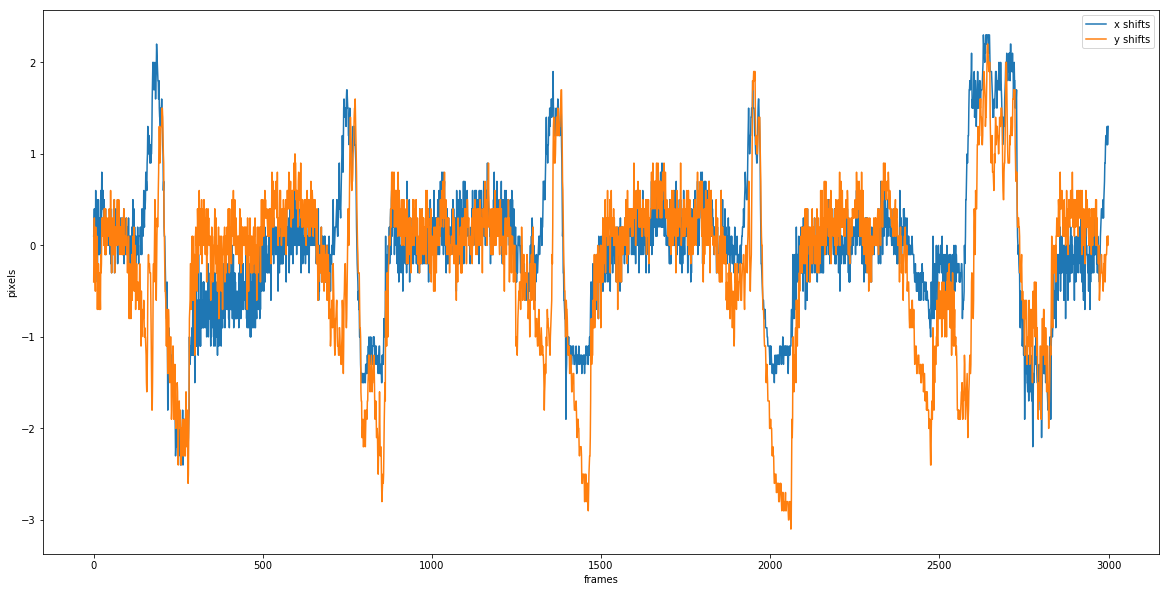

In [ ]:
#%% plot rigid shifts
pl.close()
pl.figure(figsize = (20,10))
pl.plot(mc.shifts_rig)
pl.legend(['x shifts','y shifts'])
pl.xlabel('frames')
pl.ylabel('pixels')

<h1> Piecewise rigid motion correction </h1>
<p> our video is now way less shaky but since the brain tissue is a compressible object, a non  rigid deformation still exist and in order to do a really nice source separation, needs to be corrected : </p>
<p> Here we introduce a function for a fast Non-Rigid Motion Correction based on template matching.<br/>It is a similar approach than the one presented before but on overlapping spatial patches. The estimated alignments are subsequently up-sampled to create a smooth motion field for each frame that can efficiently approximate non-rigid motion in a piecewise-rigid manner.<br/>It can be run in an online mode resulting in comparable to or even
faster than real time motion registration on streaming data.<p>
<img src="docs\img\pwrigidcorrection.png" />
<p> more info : (Eftychios A. Pnevmatikakis, Andrea Giovannucci, NormCorre) </p>
<em> http://biorxiv.org/content/biorxiv/early/2017/02/14/108514.full.pdf </em>

Adding to movie 296.0
0
saving mmap of example_movies/Sue_2x_3000_40_-46.tif
**** MOVIE NOT SAVED BECAUSE num_splits is not None ****
Adding to movie 296.0
0
saving mmap of example_movies/Sue_2x_3000_40_-46.tif
mmap


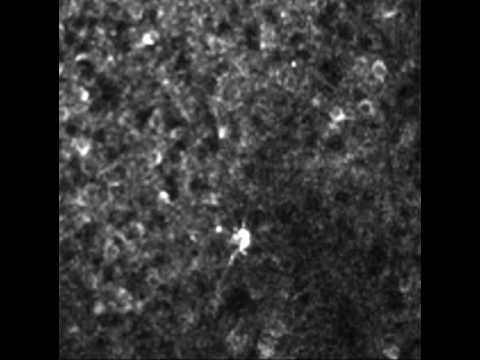

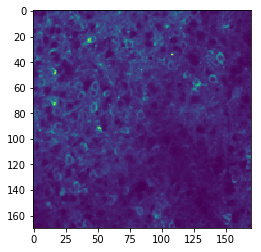

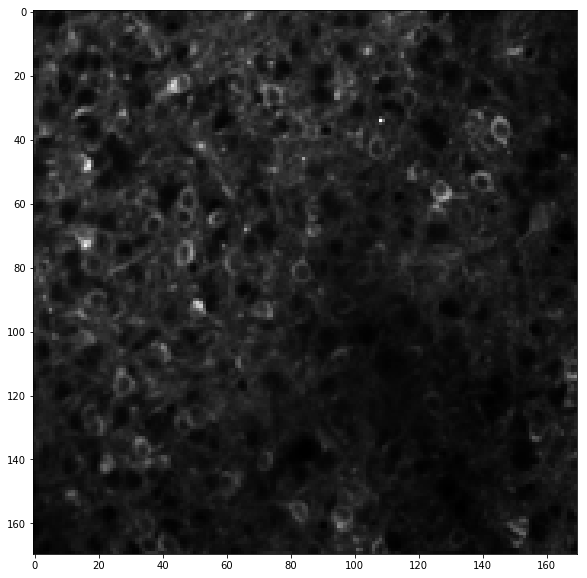

In [9]:
#%% motion correct piecewise rigid
mc.motion_correct_pwrigid(save_movie=True, template=mc.total_template_rig,
                          show_template = True)
m_els = cm.load(mc.fname_tot_els)
pl.figure(figsize = (20,10))
pl.imshow(mc.total_template_els, cmap = 'gray')
yt('JzierjDuBzg')


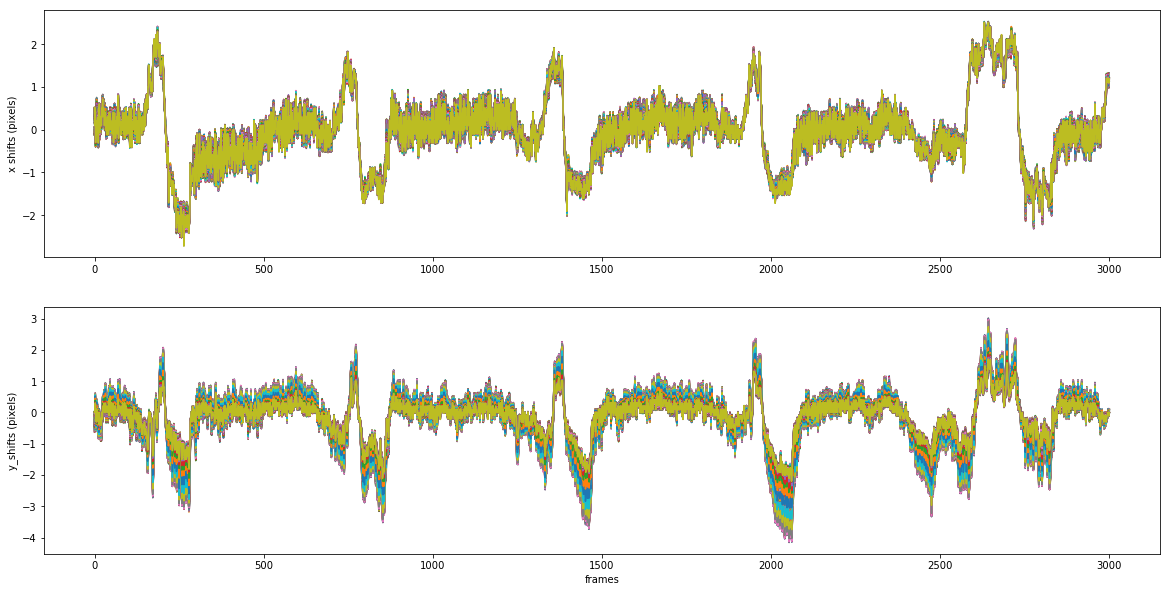

In [10]:
#%% visualize elastic shifts
pl.close()
pl.figure(figsize = (20,10))
pl.subplot(2, 1, 1)
pl.plot(mc.x_shifts_els)
pl.ylabel('x shifts (pixels)')
pl.subplot(2, 1, 2)
pl.plot(mc.y_shifts_els)
pl.ylabel('y_shifts (pixels)')
pl.xlabel('frames')
#%% compute borders to exclude
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)

reshaping along z
reshaping along z
reshaping along z
reshaping along z


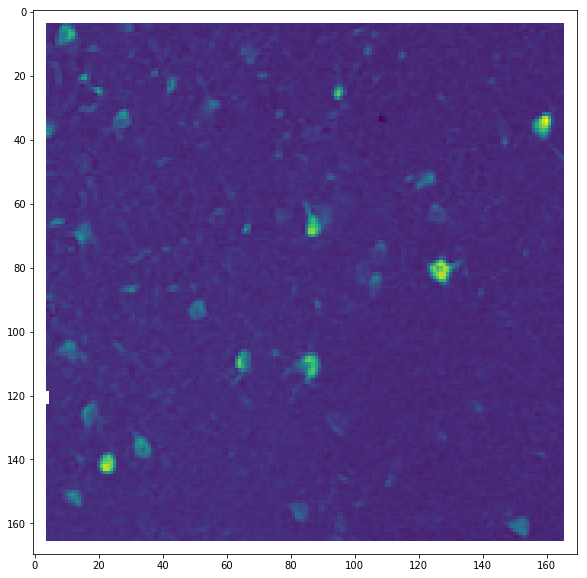

In [ ]:
# check movie
downsample_ratio = .2
m_els.resize(1, 1, downsample_ratio).play(
    gain=10, offset = 0, fr=30, magnification=2,bord_px = bord_px_els)
# compare with original and rigid corrected movies
downsample_factor = .2
cm.concatenate([m_orig.resize(1, 1, downsample_factor)+offset_mov,
                m_rig.resize(1, 1, downsample_factor), m_els.resize(
    1, 1, downsample_factor)], axis=2).play(fr=60, gain=15, magnification=2, offset=0)
#%% local correlation
pl.figure(figsize = (20,10))
pl.imshow(m_els.local_correlations(eight_neighbours=True, swap_dim=False))

<h1> Assessing Motion correction Quality </h1>
for the raw, rigid corrected and piecewise rigid corrected videos
<p> using smoothness <em> (mean over time) </em> </p>
--------------
<p> using correlation to the template <em> (Pearson Correlation coefficient)</em> </p> 
--------------
see : http://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/template_matching/template_matching.html ( like a normalized SSD )
<p> optical flow : </p>
--------------
<img src="docs/img/opticalflow.png" />
more info :<em> http://docs.opencv.org/trunk/d7/d8b/tutorial_py_lucas_kanade.html </em>

In [12]:
#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els)
winsize = 100
swap_dim = False
resize_fact_flow = .2
tmpl, correlations, flows_orig, norms, smoothness = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els, final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl, correlations, flows_orig, norms, smoothness = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig, final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl, correlations, flows_orig, norms, smoothness = cm.motion_correction.compute_metrics_motion_correction(
    fname[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

mmap
[5, -5, 5, -5]
Local correlations..
(3000, 160, 160)
Compute Smoothness.. 
Compute correlations.. 
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Compute optical flow .. 
reshaping along z
0


/Users/jeremie/anaconda2/envs/CaImAn/lib/python2.7/site-packages/numpy/linalg/linalg.py:2168: RuntimeWarning: invalid value encountered in sqrt
  ret = sqrt(sqnorm)


100
200
300
400
500
mmap
[5, -5, 5, -5]
Local correlations..
(3000, 160, 160)
Compute Smoothness.. 
Compute correlations.. 
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Compute optical flow .. 
reshaping along z
0
100
200
300
400
500
[5, -5, 5, -5]
Local correlations..
(3000, 160, 160)
Compute Smoothness.. 
Compute correlations.. 
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Compute optical flow .. 
reshaping along z
0
100
200
300
400
500


['tmpl', 'smoothness_corr', 'img_corr', 'correlations', 'flows', 'norms', 'smoothness']
example_movies/demoSue2x_els__d1_170_d2_170_d3_1_order_F_frames_3000_._metrics.npz
nan+/-nan ; 2810.28125 ; 5.005890221
mmap
['tmpl', 'smoothness_corr', 'img_corr', 'correlations', 'flows', 'norms', 'smoothness']
example_movies/demoSue2x_rig__d1_170_d2_170_d3_1_order_F_frames_3000_._metrics.npz
nan+/-nan ; 2731.03808594 ; 5.07352105901
mmap
['tmpl', 'smoothness_corr', 'img_corr', 'correlations', 'flows', 'norms', 'smoothness']
example_movies/demoSue2x_metrics.npz
nan+/-nan ; 1918.01208496 ; 5.743336641
File is:
example_movies/demoSue2xmmap


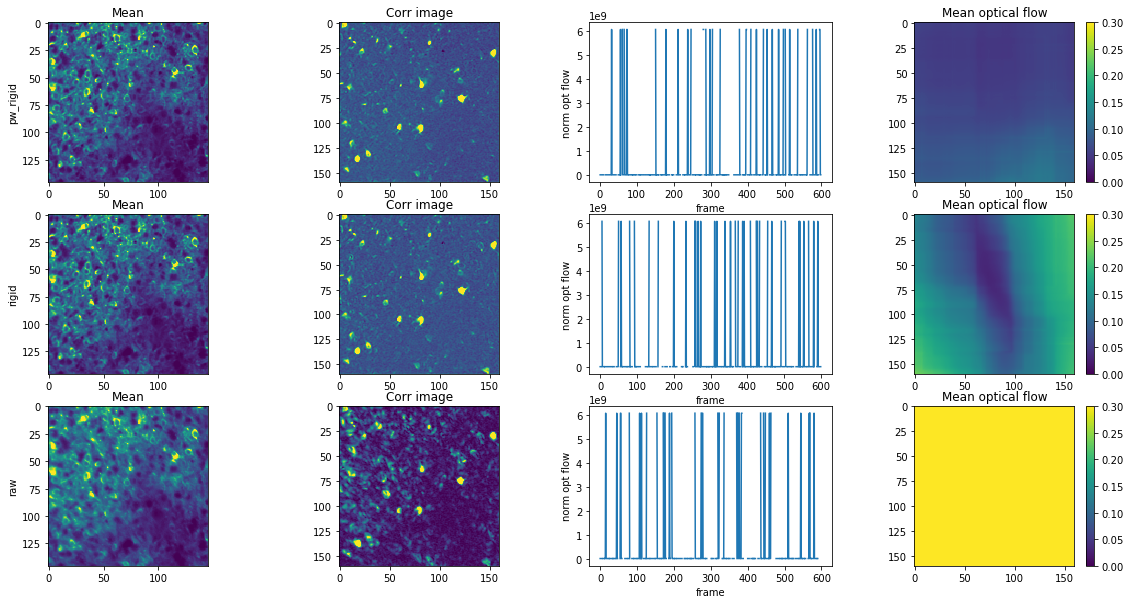

In [13]:
#%% plot the results of metrics
fls = [mc.fname_tot_els[:-4] + '_metrics.npz', mc.fname_tot_rig[:-4] +
       '_metrics.npz', mc.fname[:-4] + '_metrics.npz']
#%%
pl.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)),fls,['pw_rigid','rigid','raw']):
    with np.load(fl) as ld:
        print(ld.keys())
#        pl.figure()
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        pl.subplot(len(fls), 4, 1 + 4 * cnt)
        pl.ylabel(metr)
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + 'mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        pl.imshow(mean_img, vmin=lq, vmax=hq)
        pl.title('Mean')
        #        pl.plot(ld['correlations'])

        pl.subplot(len(fls), 4, 4 * cnt + 2)
        pl.imshow(ld['img_corr'], vmin=0, vmax=.35)
        pl.title('Corr image')
    #        pl.colorbar()
        pl.subplot(len(fls), 4, 4 * cnt + 3)
    #
        pl.plot(ld['norms'])
        pl.xlabel('frame')
        pl.ylabel('norm opt flow')
        pl.subplot(len(fls), 4, 4 * cnt + 4)
        flows = ld['flows']
        pl.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        pl.colorbar()
        pl.title('Mean optical flow')
            

<h1> Memory mapping </h1>

<p> We want the parallel processes to access and our video matrix without having it in memory and duplicating it. we are using the memapping method to fullfill such a goal</p>
<p> learn more : https://en.wikipedia.org/wiki/Memory-mapped_file </p>
<p><img src="docs/img/fordermmap.png" /></p>
<h3> Data is saved on drive so that extracting blocks of movies is efficient.  </h3>
<p>Data can be either quickly read per columns or per rows but not in both directions. So, we save the movie in such a way that it is easy to read across time.</p>


In [14]:
# MEMORY MAPPING: save each chunk in F format on memory mapped files
if 'max_shifts' not in params_movie:
    fnames = [params_movie['fname']]
    border_to_0 = 0
elif not 'overlaps'in params_movie:
    fnames = [mc.fname_tot_rig]
    border_to_0 = bord_px_rig
    m_els = m_rig
else:
    fnames = [mc.fname_tot_els]
    border_to_0 = bord_px_els
    
# if you need to crop the borders use slicing    
# idx_x=slice(border_nan,-border_nan,None)
# idx_y=slice(border_nan,-border_nan,None)
# idx_xy=(idx_x,idx_y)
idx_xy = None
add_to_movie = -np.nanmin(m_els) + 1  # movie must be positive
# if you need to remove frames from the beginning of each file
remove_init = 0
# downsample movie in time: use .2 or .1 if file is large and you want a quick answer             
downsample_factor = 1 
base_name = fname[0].split('/')[-1][:-4]
name_new = cm.save_memmap_each(fnames, dview=dview, base_name=base_name, resize_fact=(
    1, 1, downsample_factor), remove_init=remove_init, idx_xy=idx_xy,
                               add_to_movie=add_to_movie, border_to_0=border_to_0)
name_new.sort()
print(name_new)

#%% concatenate chunks if needed
if len(name_new) > 1:
    fname_new = cm.save_memmap_join(
        name_new, base_name='Yr', n_chunks=12, dview=dview)
else:
    print('One file only, not saving!')
    fname_new = name_new[0]

['example_movies/demoSue2x0000_d1_170_d2_170_d3_1_order_C_frames_3000_.mmap']
One file only, not saving!


/Users/jeremie/anaconda2/envs/CaImAn/lib/python2.7/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in divide
  return a / b


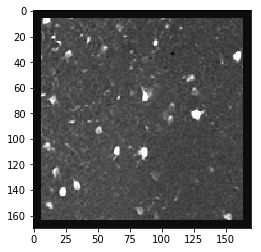

In [15]:
#%% LOAD MEMMAP FILE
# fname_new='Yr_d1_501_d2_398_d3_1_order_F_frames_369_.mmap'
Yr, dims, T = cm.load_memmap(fname_new)
d1, d2 = dims
images = np.reshape(Yr.T, [T] + list(dims), order='F')
Y = np.reshape(Yr, dims + (T,), order='F')
m_images = cm.movie(images)
#%%  checks on movies (might take time if large!)
if np.min(images) < 0:
    raise Exception('Movie too negative, add_to_movie should be larger')
if np.sum(np.isnan(images)) > 0:
    raise Exception('Movie contains nan! You did not remove enough borders')
#%% correlation image
Cn = cm.local_correlations(Y)
Cn[np.isnan(Cn)] = 0
pl.imshow(Cn, cmap='gray', vmax=.35)
#%% some parameter settings
# order of the autoregressive fit to calcium imaging in general one (slow gcamps) or two (fast gcamps fast scanning)
p = params_movie['p']  
# merging threshold, max correlation allowed
merge_thresh= params_movie['merge_thresh'] 
# half-size of the patches in pixels. rf=25, patches are 50x50
rf = params_movie['rf']  
# amounpl.it of overlap between the patches in pixels
stride_cnmf = params_movie['stride_cnmf'] 
 # number of components per patch
K =  params_movie['K'] 
# if dendritic. In this case you need to set init_method to sparse_nmf
is_dendrites = params_movie['is_dendrites']
# iinit method can be greedy_roi for round shapes or sparse_nmf for denritic data
init_method = params_movie['init_method']
# expected half size of neurons
gSig = params_movie['gSig']  
# this controls sparsity
alpha_snmf = params_movie['alpha_snmf']  
#frame rate of movie (even considering eventual downsampling)
final_frate = params_movie['final_frate']

<h1> CNMF on patches </h1>
<p> Our method builds upon and extend (Pnevmatikakis et al, Neuron, 2016)  <em> http://www.cell.com/neuron/fulltext/S0896-6273(15)01084-3 </em> </p>

<p> <img src="docs/img/cnmf1.png" /> </p>

<p> We run portion of the CNMF algorithm  on patches </p>
<p> We merge the patches with special attention to neurons on the border. </p>
<p> We refine the result by rerunning CNMF on the whole movie </p>

(3000, 170, 170)
using 4 processes
using 4000 pixels per process
using 20000 block_size
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 30)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 30)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 30)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 30)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 30)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(31, 30)
(30, 31)
(30, 31)
(30, 31)
(30, 31)
(30, 31)
(30, 31)
(30, 30)
You may think that it went well but reality is harsh
8.72283506393
Transforming patches into full matrix
Skipped %d Empty Patch 0
Generating background
using 4 processes
using 4000 pixels per process
using 20000 block_size
merging


/Users/jeremie/anaconda2/envs/CaImAn/lib/python2.7/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


[44 48 72 76]
[140 145 168 172]
[ 78 100 104]
[12 19 40]
[153 158 181]
[28 32]
[ 1 29]
[88 92]
[20 24]
[49 53]
[132 160]
[156 184]
[114 116]
[ 73 102]
[23 26]
[113 141]
[ 9 36]
[11 37]
[107 108]
[142 170]
[86 89]
[148 176]
[74 77]
[60 91]
[121 125]
[166 194]
[70 75]
[186 188]
[175 179]
[189 192]
[159 161]
[135 136]
No neurons merged!
update temporal
Generating residuals
parallel dot product block size: 20000
Start product
Transposing
19999
28899
entering the deconvolution 
53 out of total 157 temporal components updated
102 out of total 157 temporal components updated
138 out of total 157 temporal components updated
154 out of total 157 temporal components updated
157 out of total 157 temporal components updated
53 out of total 157 temporal components updated
102 out of total 157 temporal components updated
138 out of total 157 temporal components updated
154 out of total 157 temporal components updated
157 out of total 157 temporal components updated
stopping: overall temporal compone

caiman/utils/visualization.py:906: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  warn("The way to call utilities.plot_contours has changed. Look at the definition for more details.")


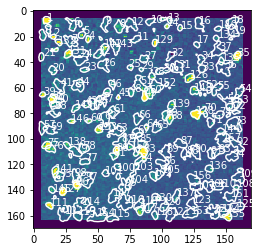

In [16]:
if params_movie['is_dendrites'] == True:
    if params_movie['init_method'] is not 'sparse_nmf':
        raise Exception('dendritic requires sparse_nmf')
    if params_movie['alpha_snmf'] is None:
        raise Exception('need to set a value for alpha_snmf')
#%% Extract spatial and temporal components on patches
t1 = time.time()
cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=0.8, p=0, 
                dview=dview, Ain=None, rf=rf, stride=stride_cnmf, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf,
                only_init_patch=True, gnb=1, method_deconvolution='oasis')
cnm = cnm.fit(images)

A_tot = cnm.A
C_tot = cnm.C
YrA_tot = cnm.YrA
b_tot = cnm.b
f_tot = cnm.f
sn_tot = cnm.sn
t2 = time.time() - t1
print(('Number of components:' + str(A_tot.shape[-1])))
#%%
pl.figure()
crd = plot_contours(A_tot, Cn, thr=0.9)

<h1>DISCARD LOW QUALITY COMPONENT </h1>
<p> The patch dubdivision creates several spurious components that are not neurons </p>
<p>We select the components according to criteria examining spatial and temporal components</p>
<img src="docs/img/evaluationcomponent.png"/>

<p> Temporal components, for each trace: </p>

<li>  compute the robust mode, corresponding to the baseline value</li>
<li> use the values under the mode to estimate noise variance</li>
<li> compute the probability of having large transients  given the noise distribution estimated </li>
<li> Threshold on this probability s.t. some of the component are discarded because lacking large enough positive transients </li>

<p> Spatial components, for each components: </p>

<li> average the frames in the moveie where the neurons is active (from temporal component), this provides a nice image of the neuron</li>
<li> compare this image with the corresponding spatial component (Person's correlation coefficient)</li>
<li> threshold the correlation coefficient  </li>


Computing event exceptionality delta
Removing Baseline
Computing event exceptionality


caiman/components_evaluation.py:129: RuntimeWarning: divide by zero encountered in log
  erf = np.log(erf)
/Users/jeremie/anaconda2/envs/CaImAn/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jeremie/anaconda2/envs/CaImAn/lib/python2.7/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Evaluating spatial footprint


caiman/components_evaluation.py:303: RuntimeWarning: invalid value encountered in greater_equal
  idx_components_r = np.where(r_values >= r_values_min)[0]  # threshold on space consistency


Keeping 77 and discarding  80


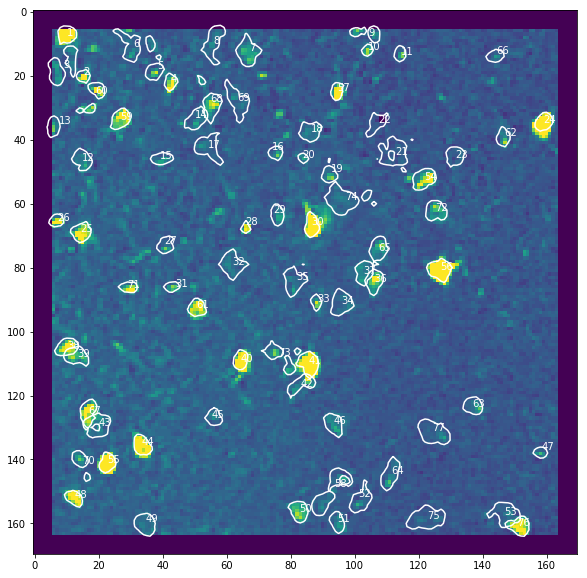

In [17]:
#%% DISCARD LOW QUALITY COMPONENT
from caiman.components_evaluation import estimate_components_quality
final_frate = params_movie['final_frate']
r_values_min = .7  # threshold on space consistency
fitness_min = -40  # threshold on time variability
# threshold on time variability (if nonsparse activity)
fitness_delta_min = -40
Npeaks = 10
traces = C_tot + YrA_tot
idx_components, idx_components_bad = estimate_components_quality(
    traces, Y, A_tot, C_tot, b_tot, f_tot, final_frate=final_frate, 
    Npeaks=Npeaks, r_values_min=r_values_min, fitness_min=fitness_min,
    fitness_delta_min=fitness_delta_min)
print(('Keeping ' + str(len(idx_components)) +
       ' and discarding  ' + str(len(idx_components_bad))))
#%%
pl.figure(figsize=(20,10))
crd = plot_contours(A_tot.tocsc()[:, idx_components], Cn, thr=0.9)


<h1> CNMF full Field of View </h1> 

In [18]:
#%%
A_tot = A_tot.tocsc()[:, idx_components]
C_tot = C_tot[idx_components]
#%% rerun updating the components to refine
cnm = cnmf.CNMF(n_processes, k=A_tot.shape, gSig=gSig, 
                merge_thresh=merge_thresh, p=p, dview=dview, Ain=A_tot, Cin=C_tot,
                f_in=f_tot, rf=None, stride=None, method_deconvolution='oasis')
cnm = cnm.fit(images)
#%%
A, C, b, f, YrA, sn = cnm.A, cnm.C, cnm.b, cnm.f, cnm.YrA, cnm.sn

(3000, 170, 170)
using 4 processes
using 4000 pixels per process
using 20000 block_size
preprocessing ...
checking if missing data
Running on 4 engines.
update spatial ...
Initializing update of Spatial Components
computing the distance indicators
found spatial support for each component
memmaping
Updating Spatial Components using lasso lars
thresholding components
Computing residuals
parallel dot product block size: 1000
Start product
Filling
--- 10.9135389328 seconds ---
Removing tempfiles created
update temporal ...
deconvolution ...
Generating residuals
parallel dot product block size: 20000
Start product
Transposing
19999
28899
entering the deconvolution 
41 out of total 77 temporal components updated
66 out of total 77 temporal components updated
75 out of total 77 temporal components updated
77 out of total 77 temporal components updated
41 out of total 77 temporal components updated
66 out of total 77 temporal components updated
75 out of total 77 temporal components updated
77

<h1> Discard low quality components on full field of view</h1>


In [30]:
#%% again recheck quality of components, stricter criteria
final_frate = params_movie['final_frate']
r_values_min = .75
fitness_min = - 50
fitness_delta_min = - 50
Npeaks = 10
traces = C + YrA
idx_components, idx_components_bad = estimate_components_quality(
    traces, Y, A, C, b, f, final_frate=final_frate,
    Npeaks=Npeaks, r_values_min=r_values_min, fitness_min=fitness_min,
    fitness_delta_min=fitness_delta_min)
print(' ***** ')
print((len(traces)))
print((len(idx_components)))
print(len(idx_components_bad))

Computing event exceptionality delta
Removing Baseline
Computing event exceptionality
Evaluating spatial footprint
 ***** 
77
67
10


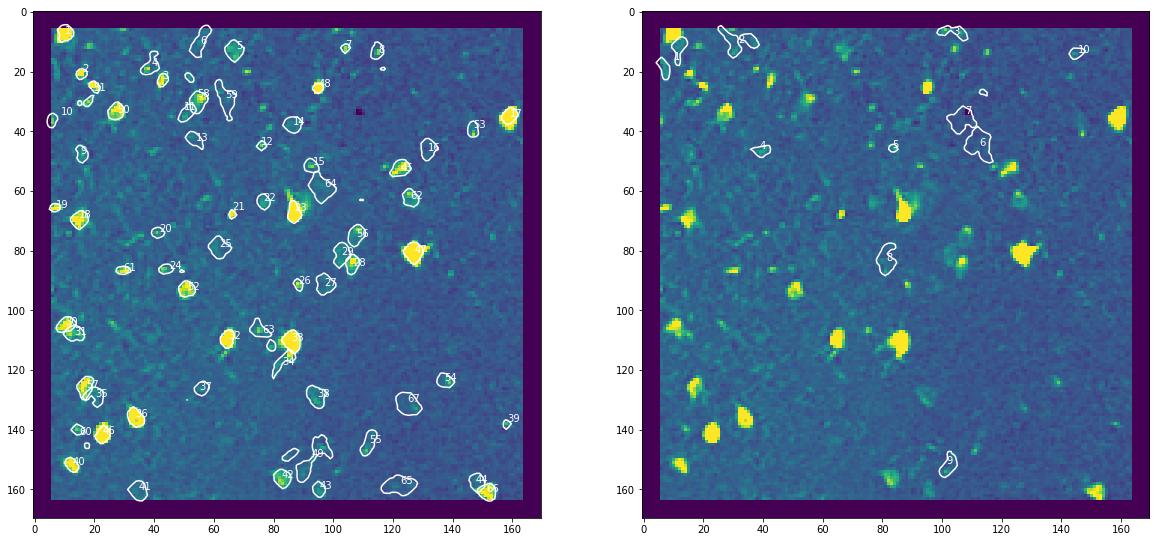

In [32]:
#%% visualize included and excluded components
pl.figure(figsize=(20,10))
pl.subplot(1, 2, 1)
crd = plot_contours(A.tocsc()[:, idx_components], Cn, thr=0.9)
pl.subplot(1, 2, 2)
crd = plot_contours(A.tocsc()[:, idx_components_bad], Cn, thr=0.9)

# kept components

In [ ]:
discard_traces_fluo=nb_view_patches(Yr,A.tocsc()[:,idx_components],
                                    C[idx_components],b,f,dims[0],
                                    dims[1],thr = 0.8,image_neurons=Cn,
                                    denoised_color='red')
print('you will may be need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# discarded components

In [ ]:
discard_traces_fluo=nb_view_patches(Yr,A.tocsc()[:,idx_components_bad],
                                    C[idx_components_bad],b,f,dims[0],dims[1],
                                    thr = 0.8,image_neurons=Cn, denoised_color='red')

we can see here a display of the components that have been kept throught the cnmf process and the one that have been discarded. 

<h1> closing, saving, and creating denoised version </h1>

In [ ]:
#%% save results
np.savez(os.path.join(os.path.split(fname_new)[0], 
                      os.path.split(fname_new)[1][:-4] + 'results_analysis.npz'),
         Cn=Cn, A=A.todense(), C=C,
         b=b, f=f, YrA=YrA, sn=sn, d1=d1, d2=d2,
         idx_components=idx_components, idx_components_bad=idx_components_bad)

In [ ]:
#%% STOP CLUSTER and clean up log files
cm.stop_server()
log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

In [ ]:
#%% reconstruct denoised movie
denoised = cm.movie(A.dot(C) + b.dot(f)).reshape(dims+(-1,),order = 'F').transpose([2,0,1])
#%% 
denoised.play(gain = 10, offset = 0,fr =100, magnification = 2)

In [ ]:
#%% reconstruct denoised movie without background
denoised = cm.movie(A.dot(C)).reshape(dims+(-1,),order = 'F').transpose([2,0,1])
#%%
denoised.play(gain = 30, offset = 0,fr =100, magnification = 2)
